# Vector space tutorial

The goal of this tutorial is to show how word co-occurrence statistics can be used to build their vectors, such that words that are similar in meaning are also close in a vectorspace.

This notebook was used to demonstrate word vectors at the Big-O London meetup.

See http://www.eecs.qmul.ac.uk/~dm303/bigo/ and http://www.meetup.com/big-o-london/events/224383139/ for more details.

## Setting up the envinroment

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas
pandas.options.display.max_columns = 11
pandas.options.display.max_rows = 5

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mplt
mplt.rcParams['font.size'] = 15
mplt.rcParams['figure.figsize'] = 15, 9
mplt.rcParams['savefig.dpi'] = 227

import numpy as np

In [2]:
from random import sample
from urllib.request import urlretrieve

import pandas as pd
import seaborn as sns 

In [3]:
def get_space(url, key='space'):
    """Download the co-occurrence data."""
    frame_file, _ = urlretrieve(url)
    return pd.read_hdf(frame_file, key=key)

# A toy example

To demonstrate the idea, we try to cluster few words by their meaning. The words are *boy*, *man*, *car*, *brother*, *uncle*, *son*, *father*, *dad*, *grandfather*, *cousin*, *parent*, *boss*, *owner*, *staff*, *adult*, *manager*, *director*, *person*, *kid*, *girl*, *woman*, *doll*, *sister*, *aunt*, *daughter*, *mother*, *mom*, *grandmother*, *idea*, *concept*, *notion*, *blue* and *pink*. 

**Task** How would you group this words? Are there words that share same theme?

In [4]:
toy_space = get_space(
    'http://www.eecs.qmul.ac.uk/~dm303/static/eecs_open14/space_frame_eecs14.h5'
)

See some of the co-occrrence statistics

In [5]:
interesting_words = ['idea', 'notion', 'boy', 'girl']

In [6]:
toy_space.loc[interesting_words]

time  year  people  way  man   ...    miner  shortage  tribunal  \
idea     258    33     324  128   84   ...        0         1         1   
notion    41     4      27   22    9   ...        0         0         0   
boy      102   102      21   62  126   ...        1         1         0   
girl     110   134      30   76  121   ...        0         0         0   

        gloucestershire  merger  
idea                  0       4  
notion                0       0  
boy                   0       0  
girl                  0       0  

[4 rows x 2000 columns]

this says us that *idea* was seen with *time* 258 times in the corpus I've used.

## Distances between 'words'

In [9]:
from sklearn.metrics.pairwise import pairwise_distances

distances = pairwise_distances(toy_space.loc[interesting_words].values, metric='euclidean')
np.round(
    pd.DataFrame(distances, index=interesting_words, columns=interesting_words),
    3,)

idea   notion      boy     girl
idea      0.000  590.686  701.158  725.698
notion  590.686    0.000  562.533  646.985
boy     701.158  562.533    0.000  243.315
girl    725.698  646.985  243.315    0.000

In [10]:
distances = pairwise_distances(toy_space.loc[interesting_words].values, metric='cosine')
np.round(
    pd.DataFrame(distances, index=interesting_words, columns=interesting_words),
    3,)

idea  notion    boy   girl
idea   -0.000   0.238  0.579  0.552
notion  0.238  -0.000  0.696  0.683
boy     0.579   0.696  0.000  0.064
girl    0.552   0.683  0.064  0.000

# Word similarity

Similarity 1 means that items are identical, 0 means that they are different. It's possible to convert distances to similarities, we use `np.exp(-distances)` here.

In [11]:
pd.DataFrame(np.exp(-distances), index=interesting_words, columns=interesting_words)

idea    notion       boy      girl
idea    1.000000  0.788367  0.560347  0.575667
notion  0.788367  1.000000  0.498630  0.505259
boy     0.560347  0.498630  1.000000  0.938117
girl    0.575667  0.505259  0.938117  1.000000

## Projecting word vectors from 2000 dimensions to 2

We are going to use scikit-learn's Manifold learning implementation.

In [12]:
from sklearn import manifold
from sklearn.preprocessing import MinMaxScaler

clf = manifold.MDS(n_components=2, dissimilarity='precomputed')
X = MinMaxScaler().fit_transform( # Normalize the values between 0 and 1 so it's easier to plot.
    clf.fit_transform(pairwise_distances(toy_space.values, metric='cosine'))
)

Now we have word vector embedding to a low dimensional space!

In [13]:
pd.DataFrame(X, index=toy_space.index)

0         1
boy   0.604378  0.630367
man   0.523278  0.492372
...        ...       ...
blue  0.321027  0.026266
pink  1.000000  0.432452

[33 rows x 2 columns]

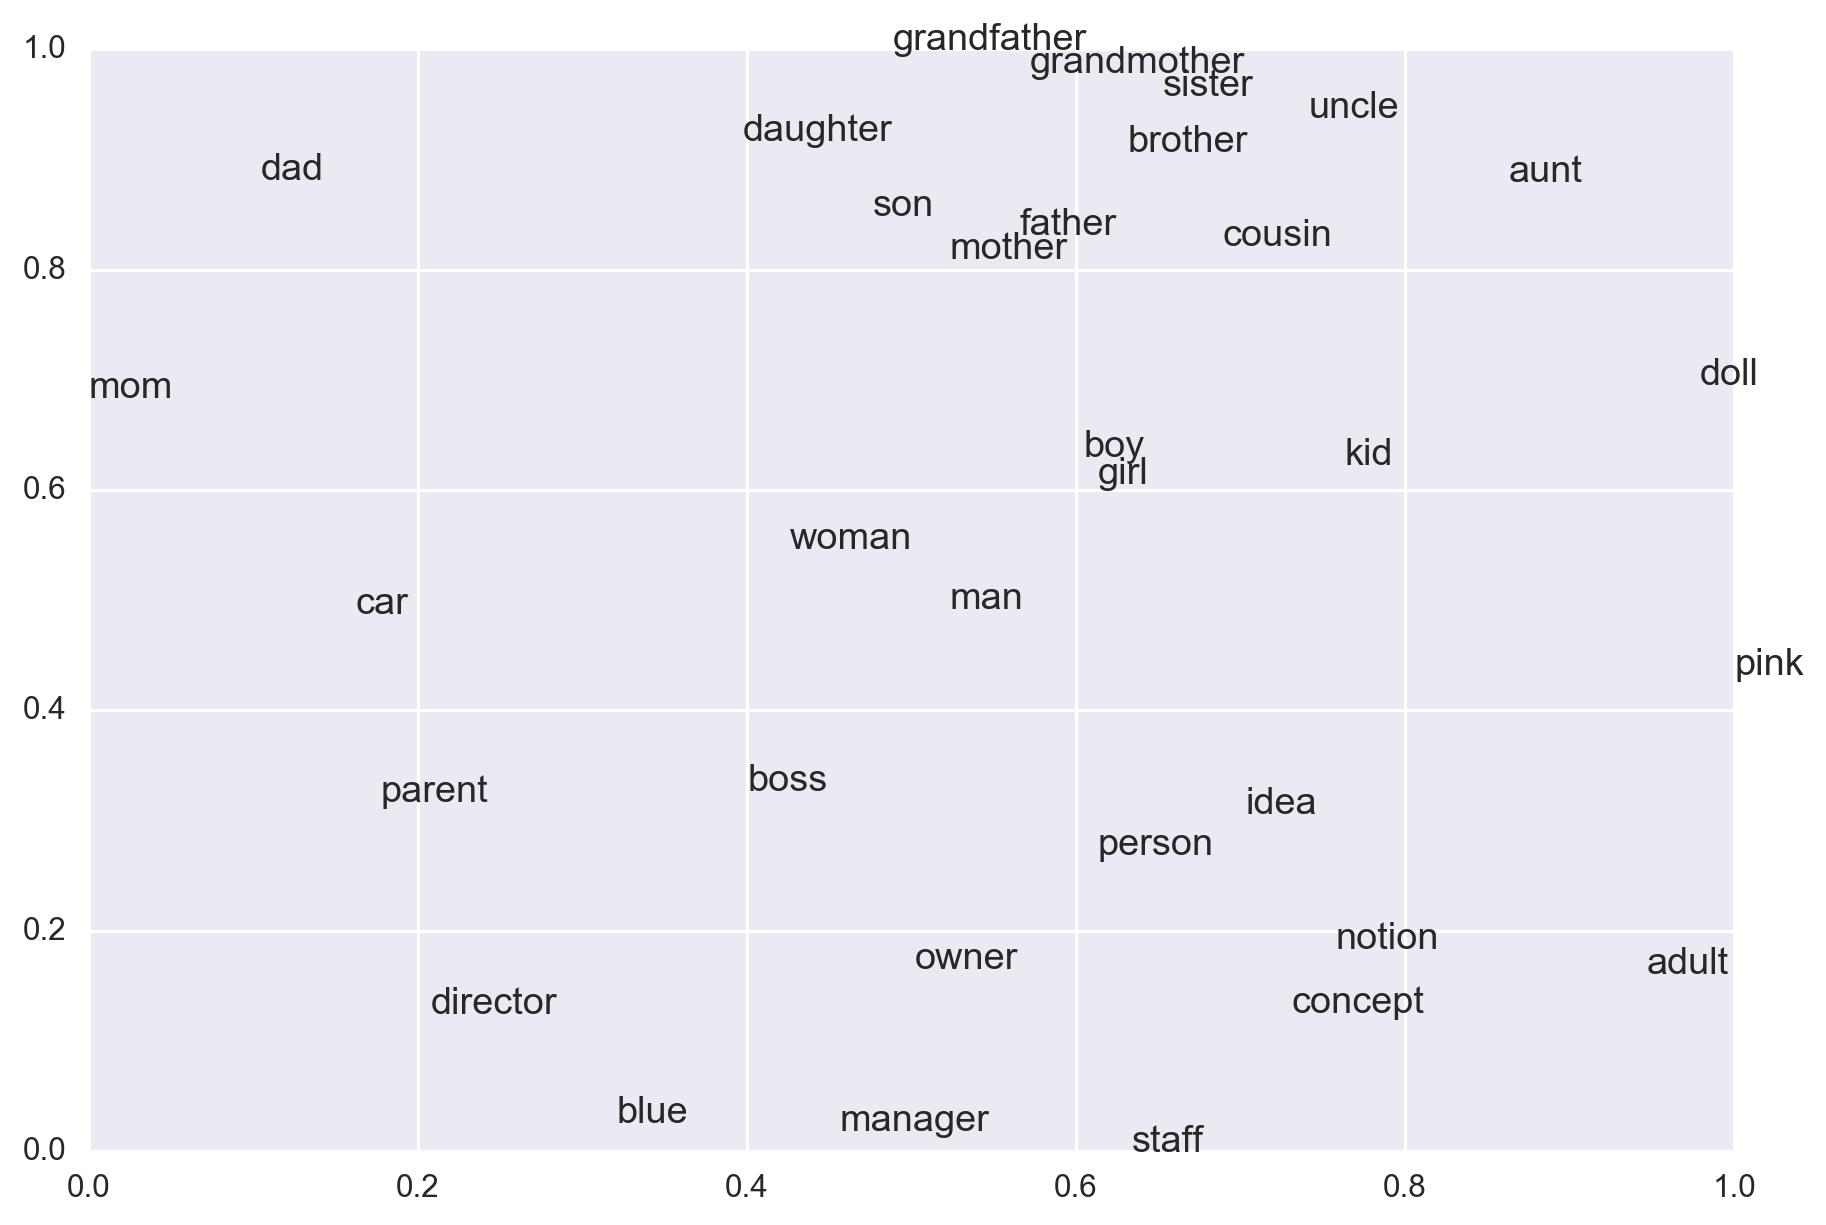

In [15]:
plt.figure()

for word, (x, y) in zip(toy_space.index, X):
    plt.text(x, y, word)
plt.tight_layout()

**Task** Do the cluster you see align with your grouping of words?

Why not to apply a Gaussian process to learn the word clusters automatically!

http://scikit-learn.org/stable/modules/gaussian_process.html

# A bigger example

In [16]:
space = get_space('http://www.eecs.qmul.ac.uk/~dm303/static/data/bigo_matrix.h5.gz')

Just an example to see what we've got there.

In [17]:
space.loc[['John', 'Mary', 'girl', 'boy'], ['tree', 'car', 'face', 'England', 'France']]

ngram  tree   car   face  England  France
ngram                                    
John     43   149   3415    21432    5806
Mary    127     0   2720    10484     733
girl      0   119  68065     3111     792
boy      46  1092  53056     2184     178

In [23]:
def plot(space, words, file_name=None):
    """Plot the `words` from the given `space`."""
    cooc = space.loc[words]
    missing_words = list(cooc[cooc.isnull().all(axis=1)].index)
    assert not missing_words, '{0} are not in the space'.format(missing_words)
        distances = pairwise_distances(cooc, metric='cosine')    
    clf = manifold.MDS(n_components=2, dissimilarity='precomputed', n_jobs=2)
    X = MinMaxScaler().fit_transform(
        clf.fit_transform(distances)
    )    
    for word, (x, y) in zip(words, X):
        plt.text(x, y, word)
    plt.tight_layout()
    
#     if file_name is not None:
#         pl.savefig(file_name)

IndentationError: unexpected indent (<ipython-input-23-06ae3c051250>, line 6)

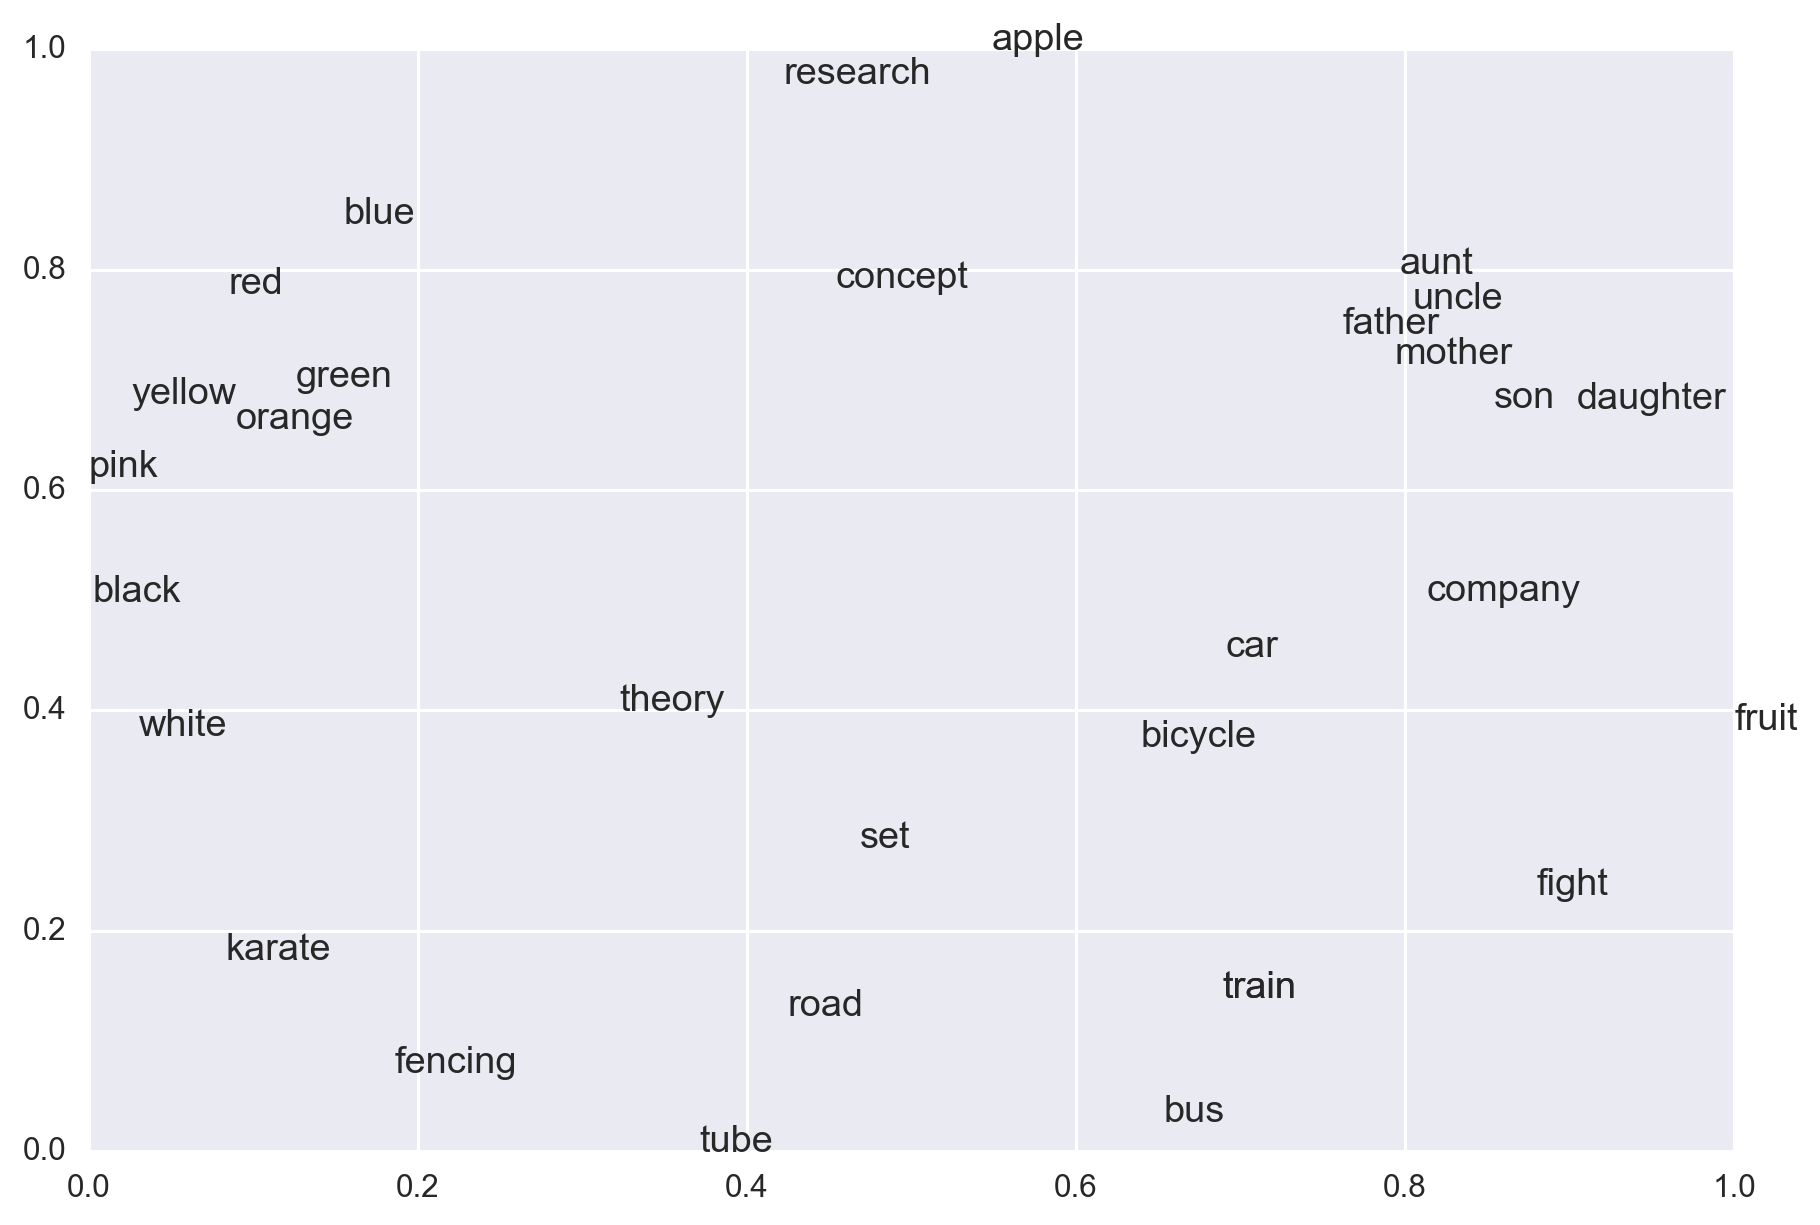

In [24]:
mplt.rcParams['font.size'] = 12
x= plot(
    space,
    (
        'red orange pink green blue white yellow black '
        'mother father son daughter aunt uncle '
        'concept research theory '
        'car bus tube road bicycle train '
        'karate fight fencing '
        'apple company fruit train set '
        ''.split()
    )
)

## 1000 randomly selected words

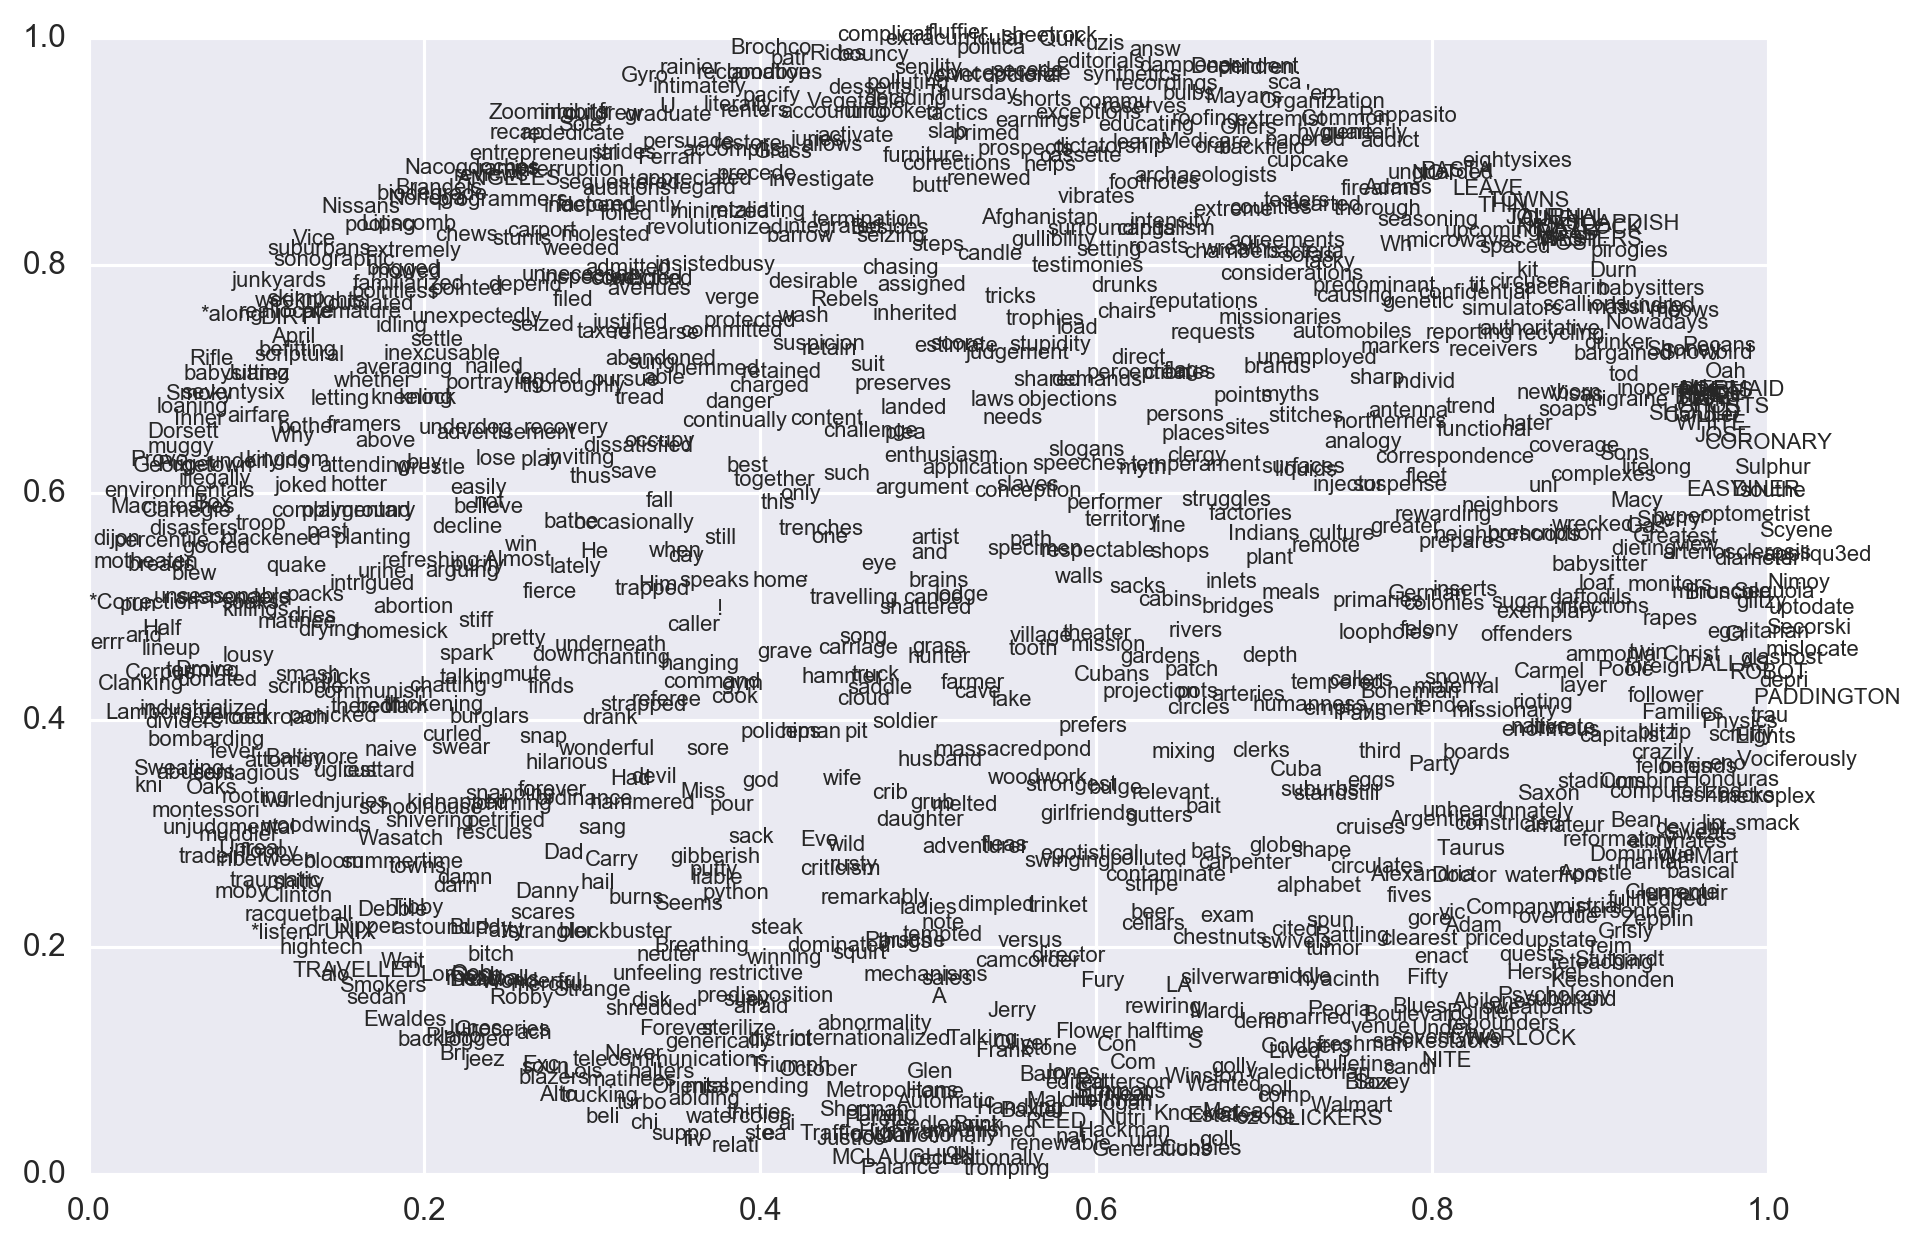

In [25]:
mplt.rcParams['font.size'] = 7
plot(space, sample(list(space.index.values), 1000))

## A selection of words from 10000 most frequent

In [26]:
most_frequent_words = (
    space
    .sum(axis=1)
    .sort(ascending=False, inplace=False)
    [:10000]
)

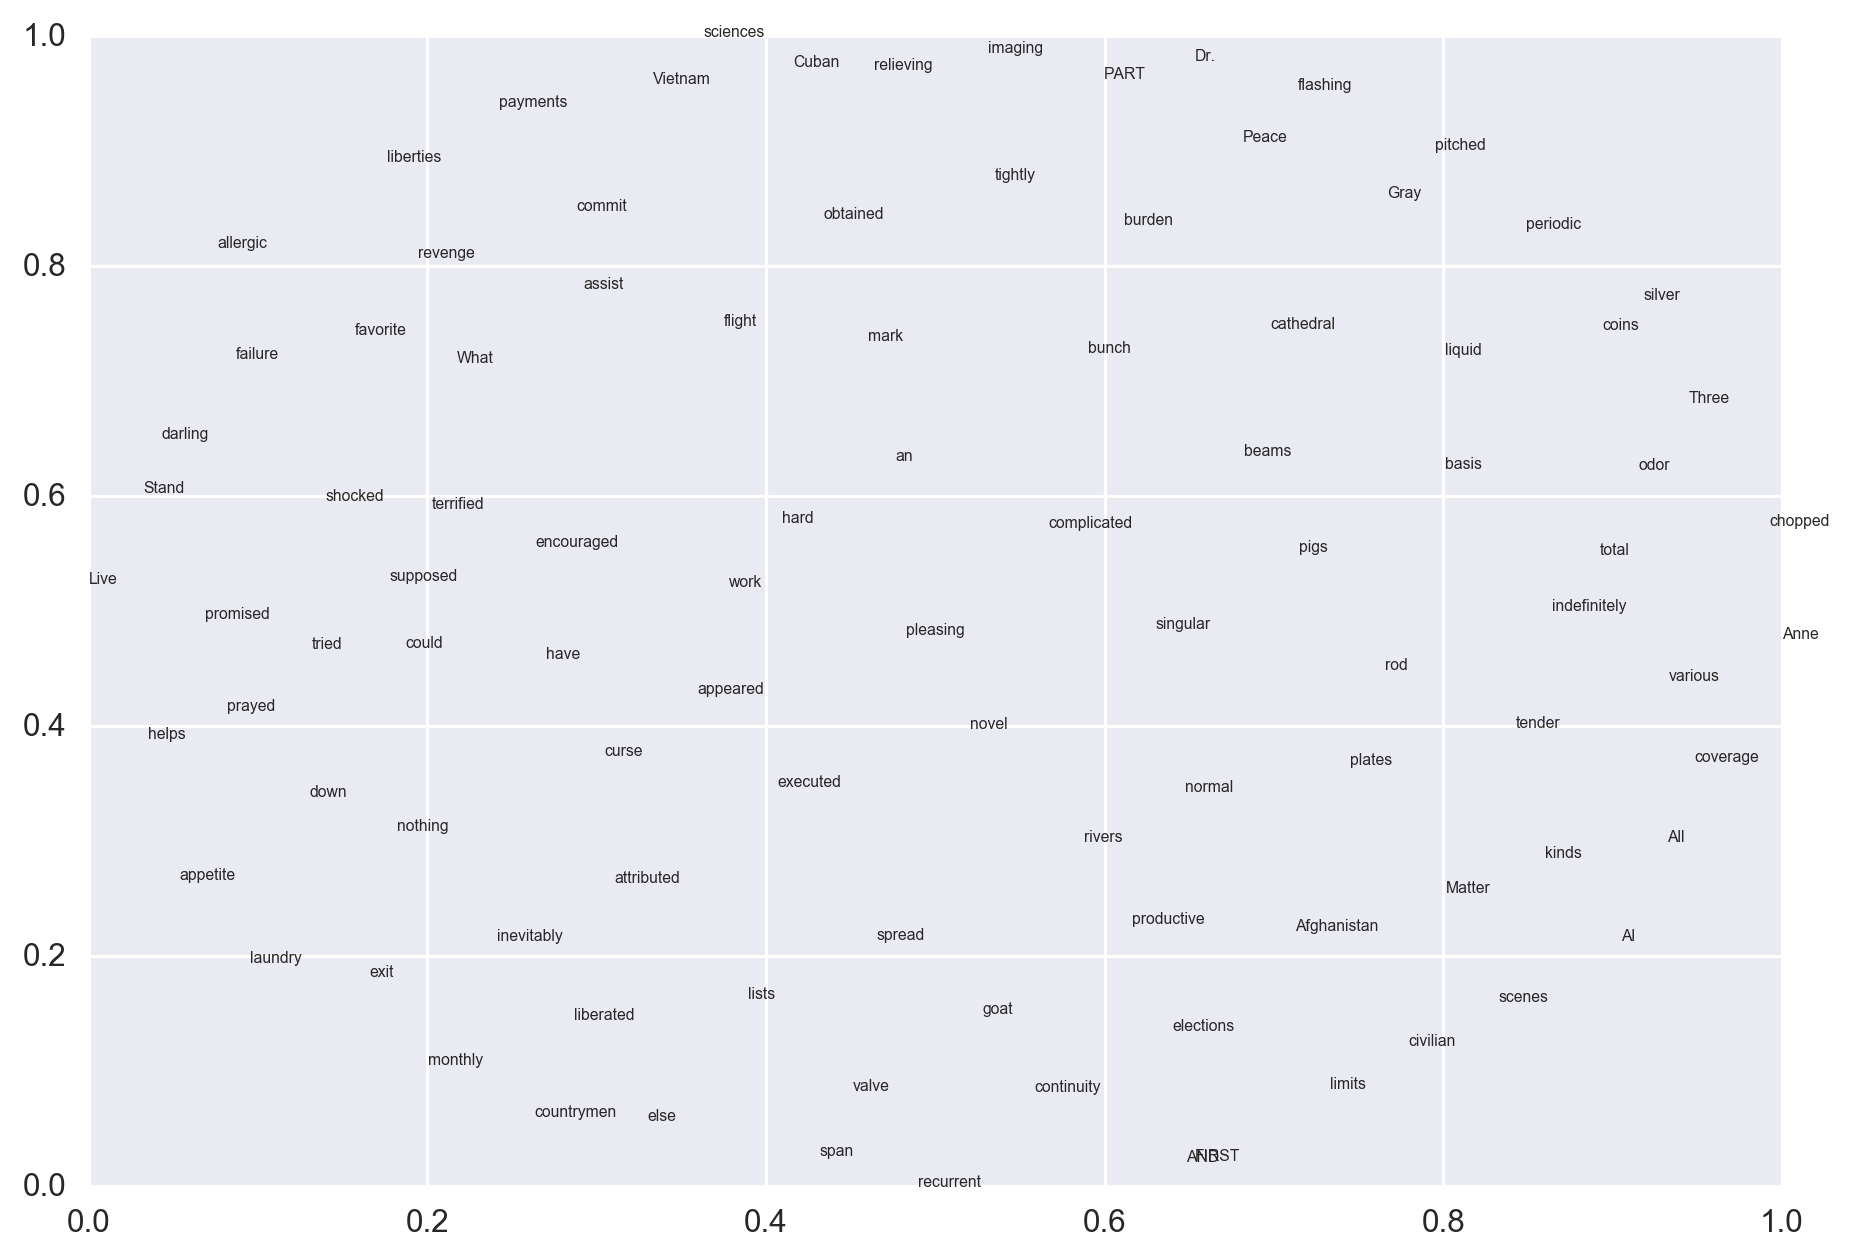

In [27]:
mplt.rcParams['font.size'] = 5
plot(space, sample(list(most_frequent_words.index), 100))

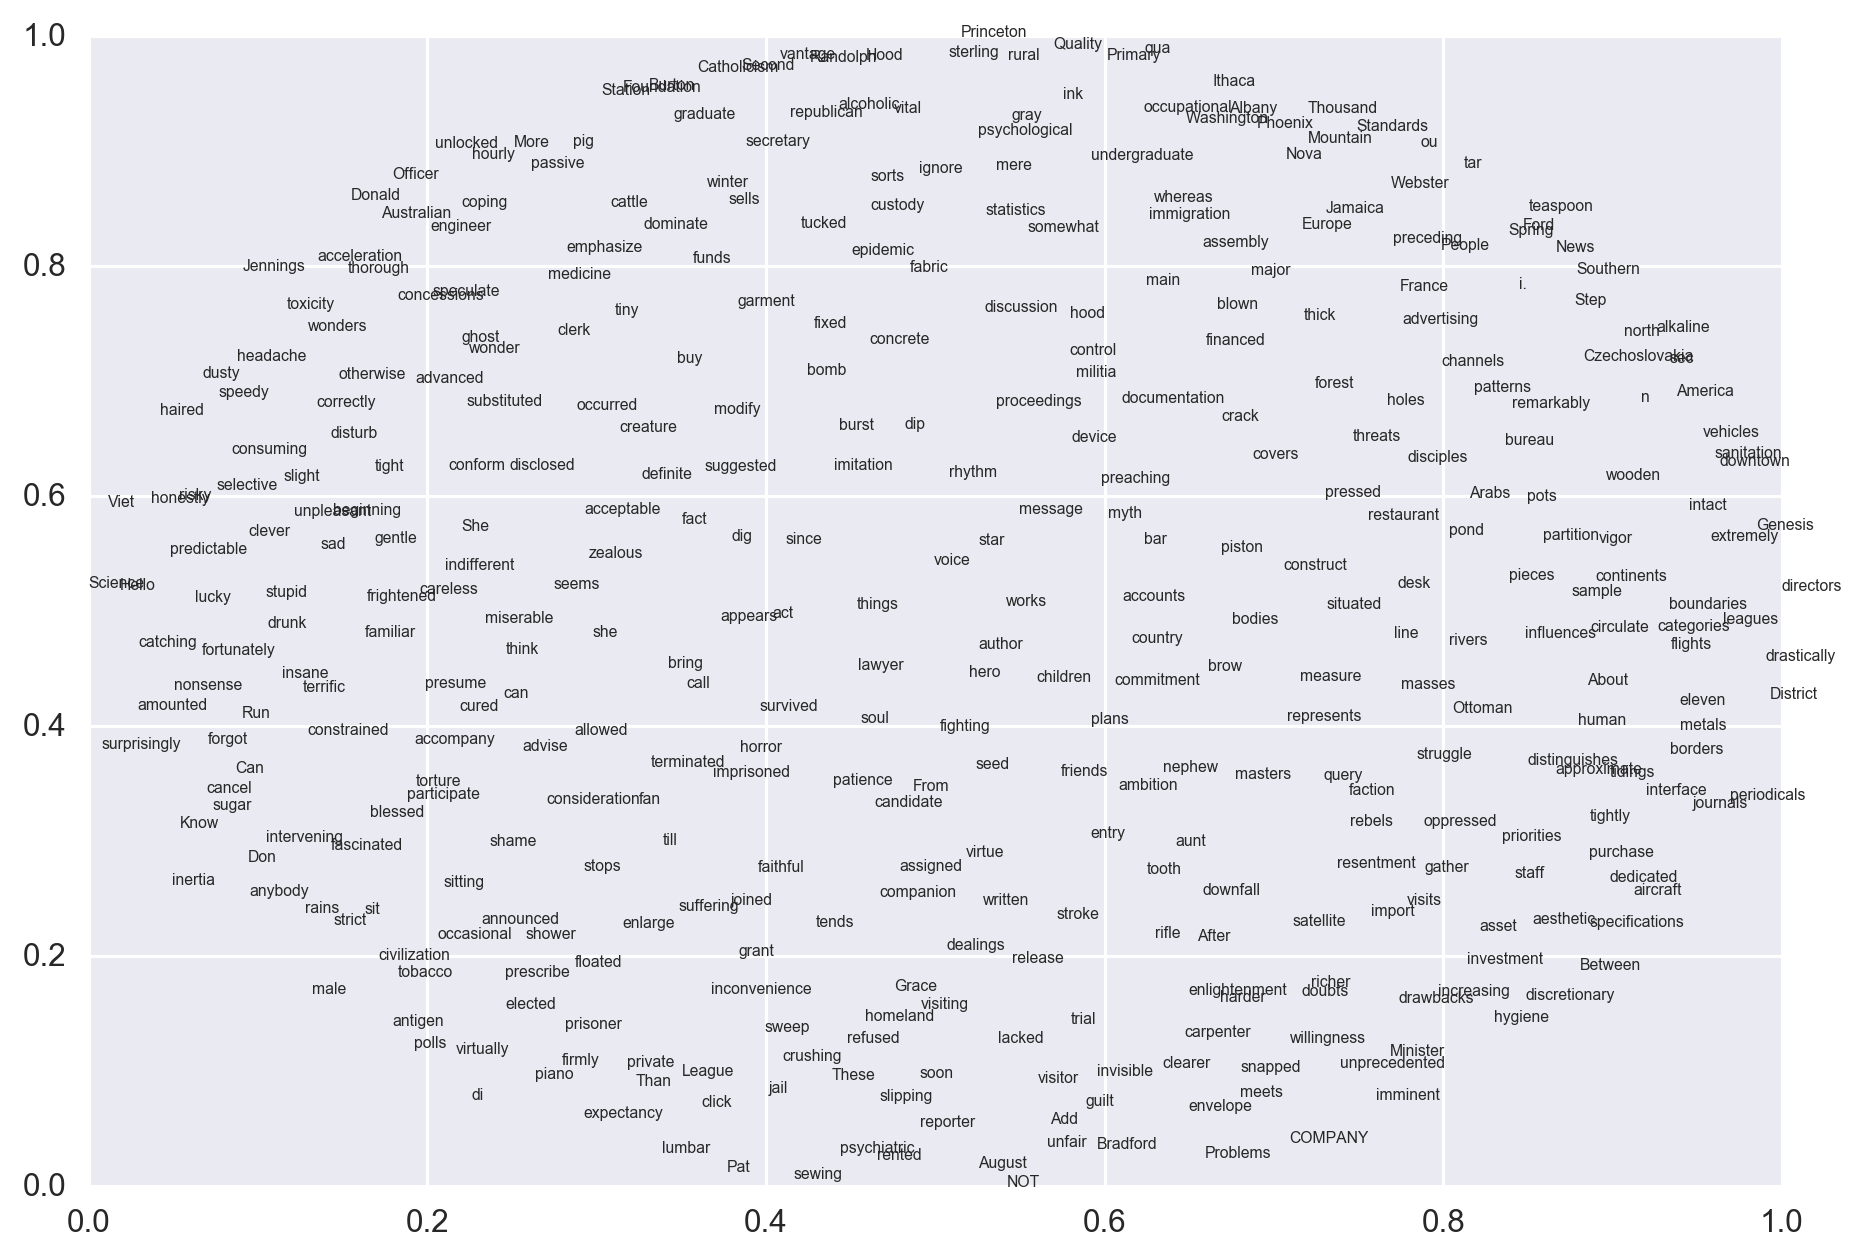

In [28]:
mplt.rcParams['font.size'] = 5
plot(space, sample(list(most_frequent_words.index), 400))

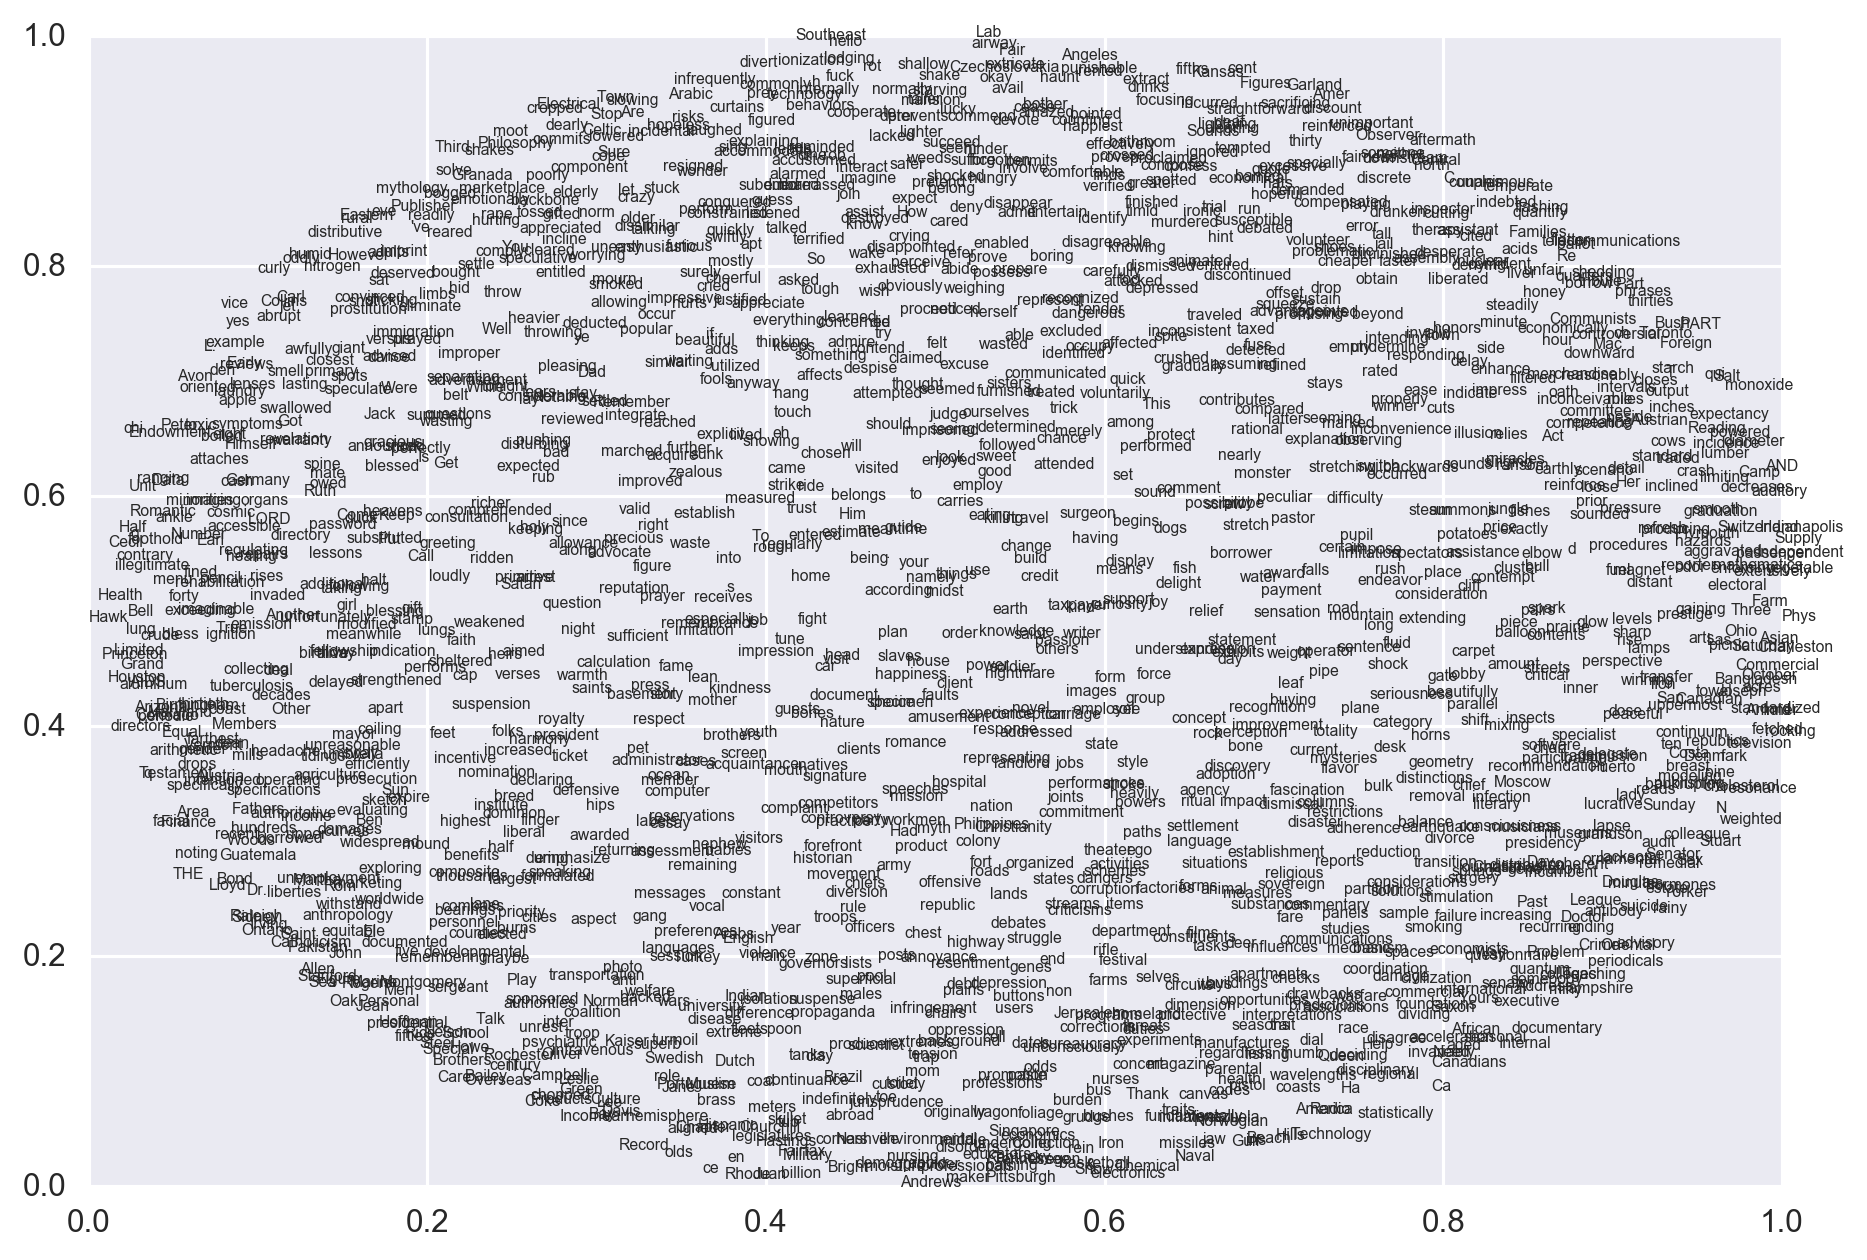

In [29]:
mplt.rcParams['font.size'] = 5
plot(space, sample(list(most_frequent_words.index), 1600))